<a href="https://colab.research.google.com/github/Mvoii/myspotify-analysis/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
filename = "musicthatjigglesmybooty_24.csv"

from matplotlib import pyplot
import seaborn
import pandas as pd
from collections import defaultdict
from scipy.stats import pareto, gamma
from datetime import date

# read the data
data = pd.read_csv(filename)
# data.drop("Unnamed: 0", axis=1, inplace=True)
print("total songs:", data.shape[0])
print(data[:3])

total songs: 4027
                 Track ID                     Track Name  \
0  7zOQjZxFhND5uHScE6uVbt                 Bad To Di Bone   
1  5vmRQ3zELMLUQPo2FLQ76x                  Smalltown Boy   
2  1Fka6XCbSxs4ElXQOe28xf  Sun Is Shining - De Luxe Edit   

                        Album Name    Artist Name(s) Release Date  \
0  Bad To Di Bone (Canada Version)      Brick & Lace   2009-01-01   
1               The Age of Consent      Bronski Beat   1984-10-15   
2         Sun Is Shining (Remixes)  Funkstar De Luxe   2017-05-01   

   Duration (ms)  Popularity  Added By              Added At  \
0         203706          28       NaN  2024-11-24T15:52:36Z   
1         302413          79       NaN  2024-11-24T09:35:44Z   
2         234000          54       NaN  2024-11-24T09:30:32Z   

                                              Genres  ...   Key  Loudness  \
0                                      reggae fusion  ...  11.0    -4.741   
1  hi-nrg,new romantic,new wave,new wave pop,soph... 

In [15]:
data.columns

# data = data.dropna('Artist Name(s)', inplace=True)
# count the nan values
count_nan = data['Artist Name(s)'].isnull().sum()
print("nan values; "+str(count_nan))

#data = data.dropna().reset_index(drop=True)

count_nan = data['Artist Name(s)'].isnull().sum()
print("nan values; "+str(count_nan))

nan values; 0
nan values; 0


number of unique artists: 2758


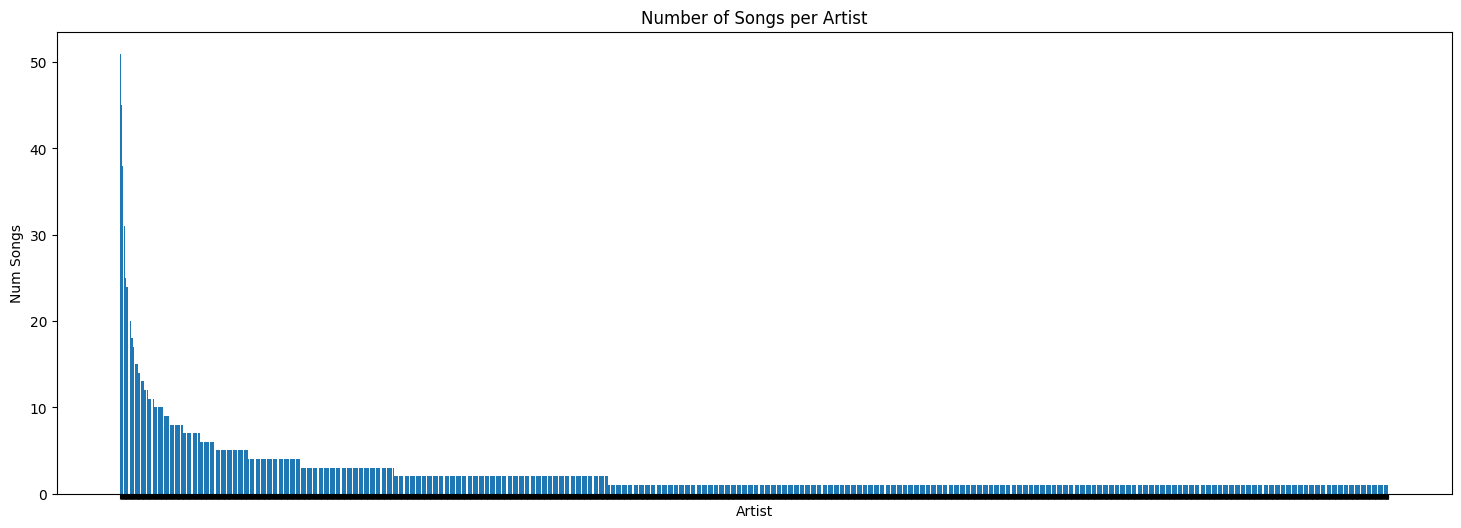

In [18]:
# count songs per artist
# data = data.fillna()
artists = defaultdict(int)
for i, song in data.iterrows():
    artist_names = [song['Artist Name(s)']]

    for musician in song['Artist Name(s)'].split(','):
      artists[musician] += 1
      # print(f"found artists; {artist_names}")

# sort for chart
artists = pd.DataFrame(artists.items(), columns=['Artist', 'Num Songs']
                        ).sort_values('Num Songs', ascending=False).reset_index(drop=True)
print("number of unique artists:", artists.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists['Artist'], artists['Num Songs'])
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title(f"Number of Songs per {artists.columns[0]}")
pyplot.show()



Note I've attributed songs with multiple artists to multiple bars, so the integral here is the number of unique song-artist pairs, not just the number of songs.

It seems to follow a Pareto distribution. Let's try to fit one

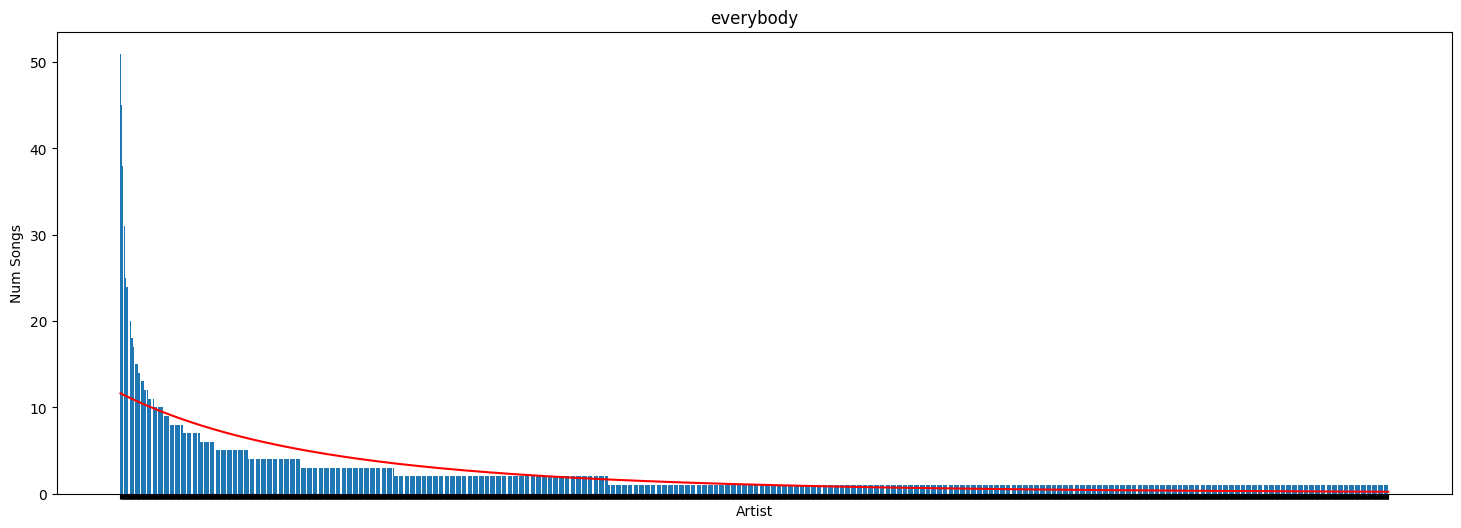

In [23]:
# finding the best params: need x, y data 'sampled'
# from the distribution for parameter fit

y = []
for i in range(artists.shape[0]):
  for j in range(artists["Num Songs"][i]):
    y.append(i) # just let y have index[artist] repeated for each song


# sanity check, if dataframe is not sorted properly, y isn't either
# pyplot.figure()
# pyplot.hist(y, bins=30)

# the docs is bad but this is okay
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-
# ones-with-scipy-python
param = pareto.fit(y, 100)
pareto_fitted = len(y) * pareto.pdf(range(artists.shape[0]), *param)
# param = gamma.fit(y) # gamma fits abysmally: see for yourself
# gamma_unfitted = len(y)*gamma.pdf(range(artists.shape[0]), *parma))

pyplot.figure(figsize=(18, 6))
pyplot.bar(artists["Artist"], artists["Num Songs"])
pyplot.plot(pareto_fitted, color='r')
# pyplot.plot(gamma_fitted, color='g')
pyplot.xticks(visible=False)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("everybody");



Best fit is still too sharp for the data, and I tried for a good long while to get it to fit better, so I conclude this doesn't quite fit a power law.

Let's plot the top 50 artists so we can actually read who they are.


Text(0.5, 1.0, 'top 50 artists')

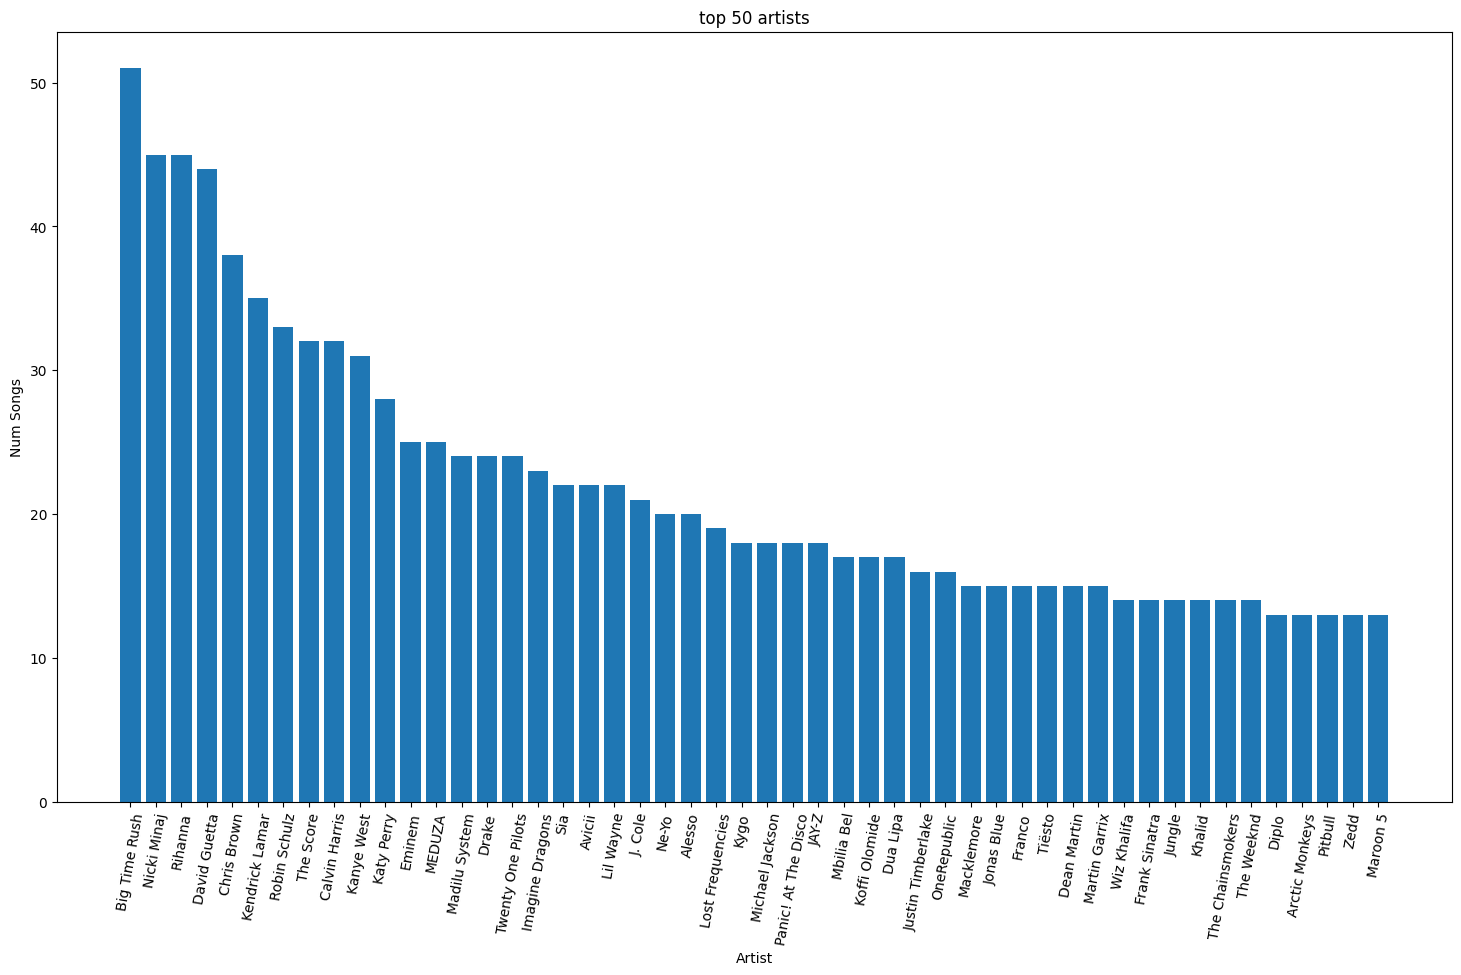

In [24]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(artists["Artist"][:50], artists["Num Songs"][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(artists.columns[0])
pyplot.ylabel(artists.columns[1])
pyplot.title("top 50 artists")

## Volume Added Over Time
My proclivity to add songs to this playlist is a proxy for my interest in listening to music generally. How has it waxed and waned over time?

Text(0.5, 1.0, 'Volume Added Over Time')

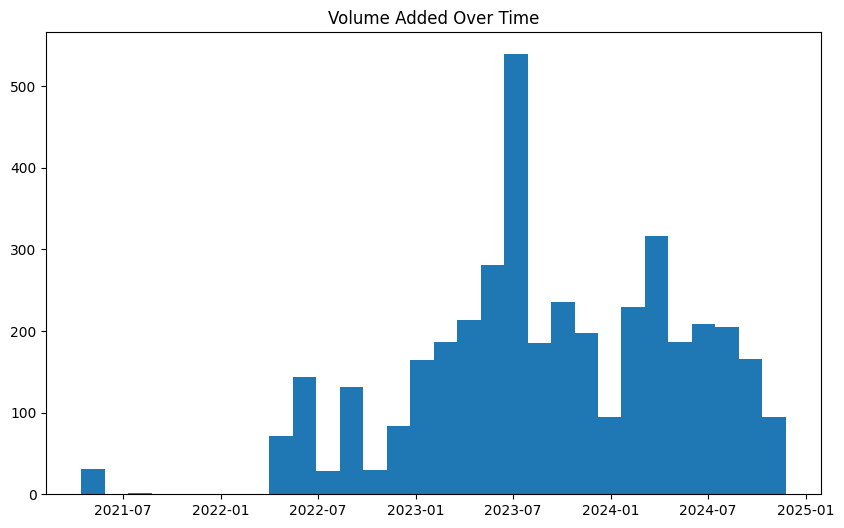

In [25]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # to suppress the warnings

# plot of added volume over time
parse_date = lambda d:(int(d[:4]), int(d[5:7]), int(d[8:10]))
pyplot.figure(figsize= (10, 6))
pyplot.hist([date(*parse_date(d)) for d in data["Added At"]], bins=30)
pyplot.title('Volume Added Over Time')

The initial spike is from when I first stared using Spotify as the home for this collection and manually added hundreds from my previous list.


## Eclecticness Measure (Frequency Transform)

This one is a personal favorite. I want to know how many of my songs are one-offs from that artist for me--just individual pieces I found fantastic and ended up adding after a few listens--, how many are two-offs, et cetera. I know it must be heavily skewed toward the low numbers.


number of song-artists pairs represented in teh eclecticness chart: 6436


Text(0, 0.5, 'Volume')

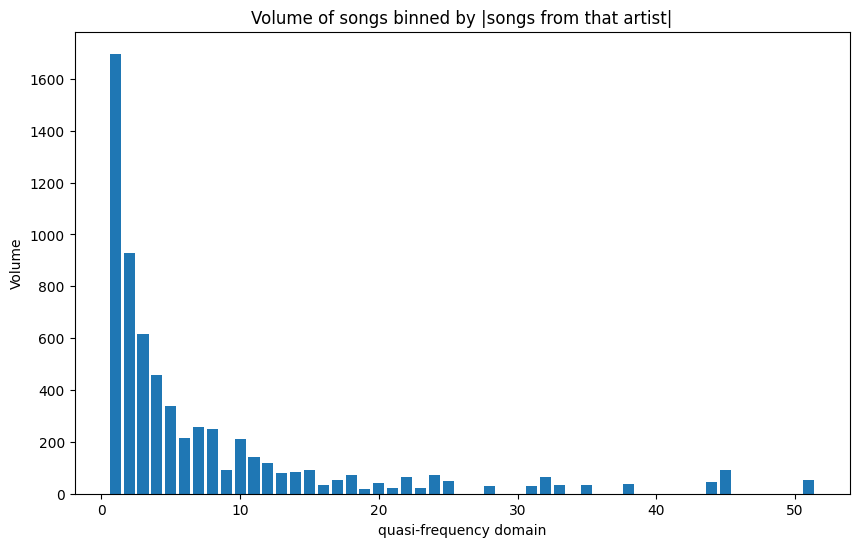

In [27]:
# bar chart of first bar chart == hipster diversity factor
frequency = defaultdict(int)
for n in artists["Num Songs"]:
  frequency[n] += n
frequency = pd.DataFrame(frequency.items(), columns=["Unique Count", "Volume"]
                         ).sort_values("Volume", ascending=False)
print("number of song-artists pairs represented in teh eclecticness chart:",
      sum(frequency["Volume"]))

pyplot.figure(figsize=(10, 6))
pyplot.bar(frequency["Unique Count"], frequency["Volume"].values)
pyplot.title("Volume of songs binned by |songs from that artist|")
pyplot.xlabel("quasi-frequency domain")
pyplot.ylabel(frequency.columns[1])



So, yes, it's much more common for an artist to make it in my list a few times than many times. In fact, the plurality of my top songs come from unique artists.

Conversely, this view also makes stark those few musicians from whom I've collected dozens.

Note that here, as in the artist bar charts, some songs are doubly-counted, because in cases artists collaborated I listed the song in both bins.



## Genres Bar Chart

Alright, enough messing around. All the above were possible with the output from Watsonbox's Exportify. Let's get to the novel stuff you came here for.

People describe music by genre. As we'll see, genre names are flippin' hilarious and extremely varied, but in theory if I cluster around a few, that should give you a flavor of my tastes.


Number of unique genres: 943


Text(0.5, 1.0, 'Number of Songs per genre')

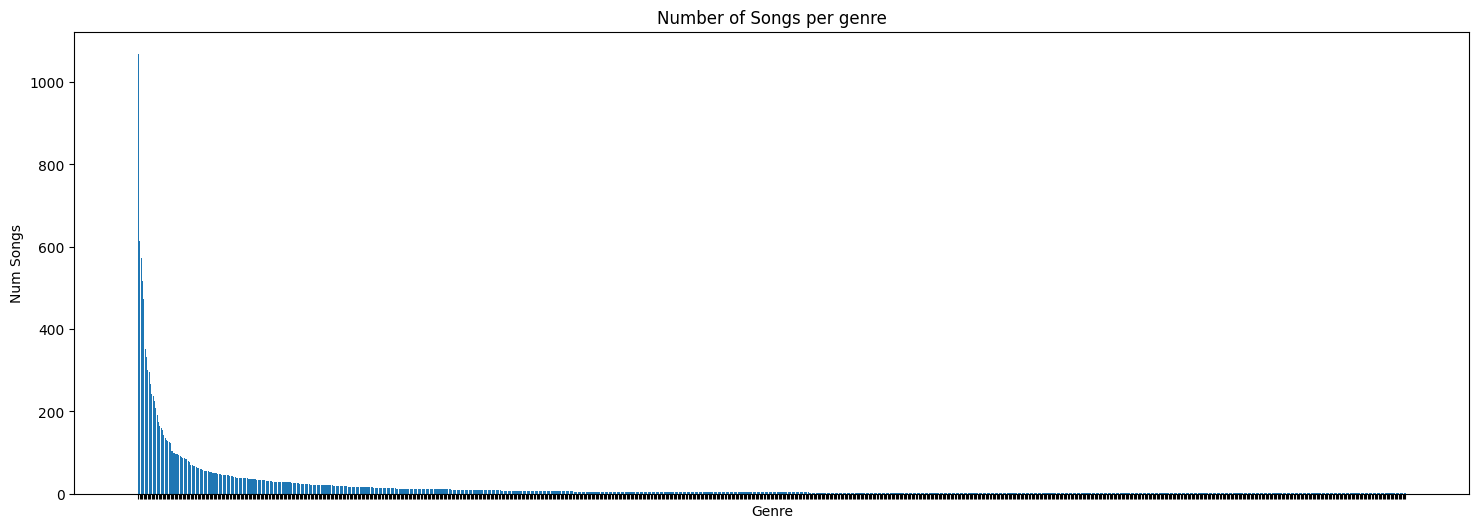

In [30]:
# count songs per genre
genres = defaultdict(int)
for i, song in data.iterrows():
  if type(song["Genres"]) is str: # sometimes they aren't any, thus NaN
    for genre in song["Genres"].split(','):
      if len(genre) > 0:  # empty str seems to be a legit genre
        genres[genre] += 1

# sort for chart
genres = pd.DataFrame(genres.items(), columns=["Genre", "Num Songs"]
                      ).sort_values("Num Songs", ascending=False).reset_index(drop=True)
print("Number of unique genres:", genres.shape[0])

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres["Genre"], genres["Num Songs"])
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Number of Songs per genre")

so many! Lets do the same thing as we did with artists and for giggles see if it fits a powerlaw

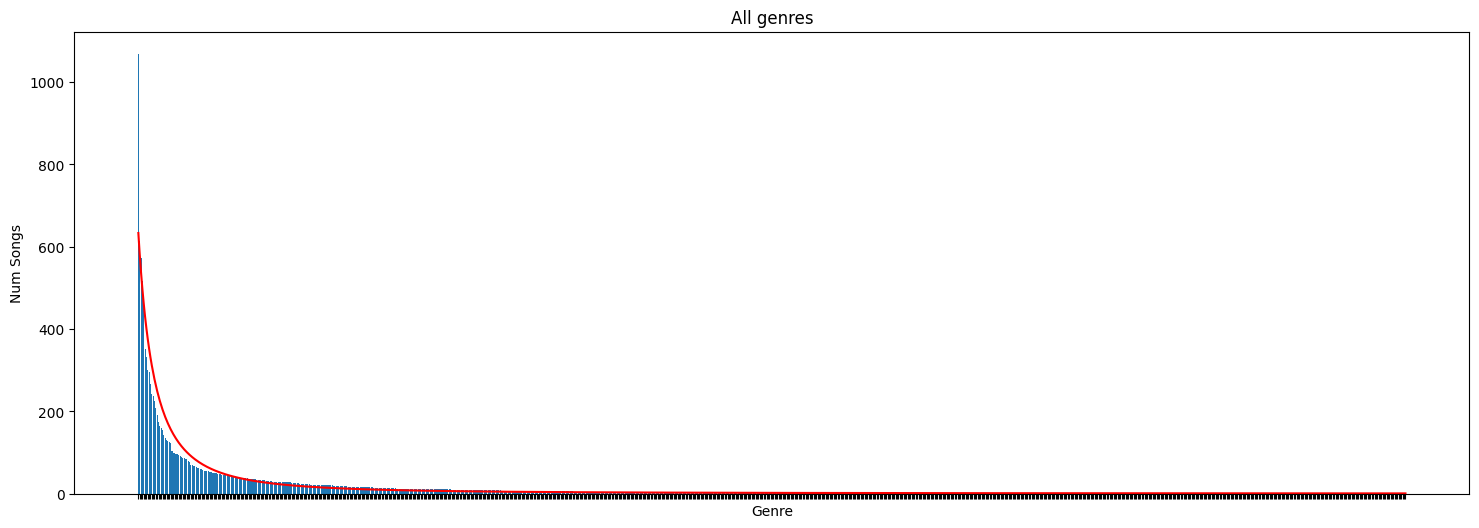

In [31]:
y = []
for i in range(genres.shape[0]):
  for j in range(genres["Num Songs"][i]):
    y.append(i)

# sanity check
# pyplot.figure()
# pyplot.hist(y, bins=30)

param = pareto.fit(y, 100)
pareto_fitted = len(y) * pareto.pdf(range(genres.shape[0]), *param)

pyplot.figure(figsize=(18, 6))
pyplot.bar(genres["Genre"], genres["Num Songs"])
pyplot.plot(pareto_fitted, color='r')
pyplot.xticks(visible=False)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("All genres");



Still too sharp, but fits better than with the artists.

Let's look at the top 50 so we can read the names.


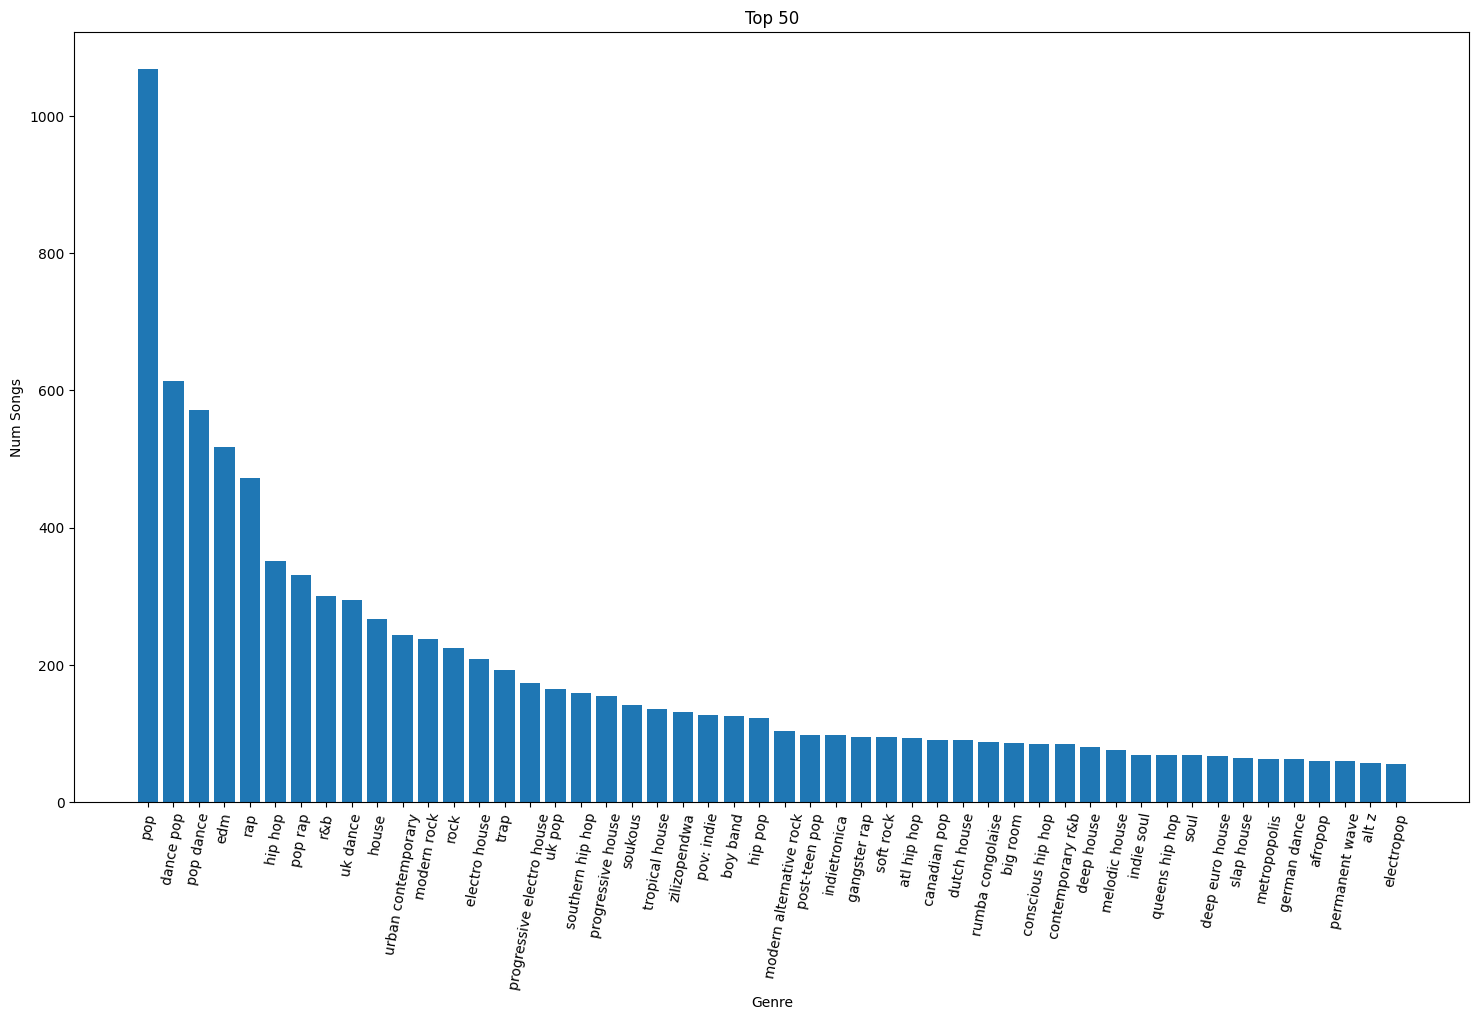

In [32]:
pyplot.figure(figsize=(18, 10))
pyplot.bar(genres["Genre"][:50], genres["Num Songs"][:50])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Top 50");

"Talent show" lol. wtf? "Big Room", "pov:indie", "soukous", "Tropical House", "Electro-House", "Indietronica", "Neo Soul", "Mellow gold"

well, not that much of a change n the top 3, but some significant changes in the rest

let's take a look at the least popular names, unique ones at the bottom

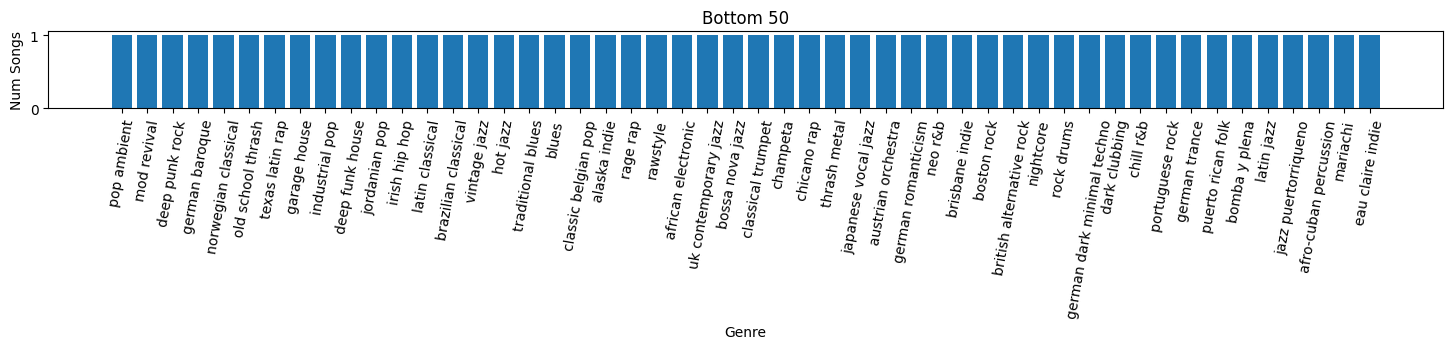

In [33]:
pyplot.figure(figsize=(18, 1))
pyplot.bar(genres["Genre"][-50:], genres["Num Songs"][-50:])
pyplot.xticks(rotation=80)
pyplot.xlabel(genres.columns[0])
pyplot.ylabel(genres.columns[1])
pyplot.title("Bottom 50");

Bummer, not as many exciting names as there were last time


## Release Dates

Which era of music do I prefer?


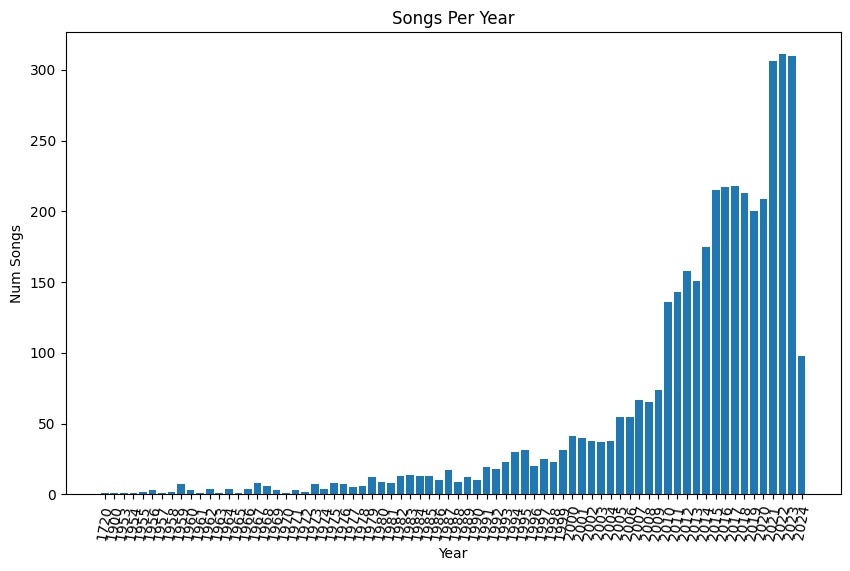

In [34]:
years = defaultdict(int)
for i, song in data.iterrows():
    years[song["Release Date"][:4]] += 1

years = pd.DataFrame(years.items(), columns=["Year", "Num Songs"]
                        ).sort_values("Year")

pyplot.figure(figsize=(10, 6))
pyplot.bar(years["Year"], years["Num Songs"])
pyplot.xticks(rotation=80)
pyplot.xlabel(years.columns[0])
pyplot.ylabel(years.columns[1])
pyplot.title("Songs Per Year");

It seems to follow a Gamma distribution! This makes sense because I'm more likely to have heard things that are nearer me in time, and it takes a while for them to get through my process and become favorites.



In [35]:
# Some years are missing, so transform to a dataframe that covers full time perios
#eldest = int(years["Year"].values[0])
#youngest = int(years["Year"].values[-1])
#missing_years = [str(x) for x in range(eldest+1, youngest) if
#                 str(x) not in years["Year"].values]
#ago = years._append(pandas.DataFrame.from_dic(
#    {"Year": missing_years, "Num Songs": [0 for x in range(len(missing_years))]})
#                  ).sort_values("Year", ascending=False).reset_index(drop=True)
#y = []
#for i in range(ago.shape[0]):
#    for j in range(int(ago["Num Songs"][i])):
 #       y.append(i)

# sanity check histogram to make sure I'm constructing properly
# pyplot.figure()
# pyplot.hist(y, bin=30)

#param = gamma.fit(y, 10000)
#gamma_fitted = len(y)*gamma.pdf(range(ago.shape[0]), *param)

#pyplot.figure(figsiize=(10, 6))
#pyplot.bar(range(len(ago["Year"])), ago["Num Songs"])
#pyplot.plot(gamma_fitted, color='g')
#pyplot.xlabel("Years Ago")
#pyplot.ylabel(ago.columns[1])
#pyplot.title("Songs Per Year (In Absolute Time)");

print("Oldest Hall of Fame")
print(data[["Track Name", "Artist Name(s)", "Release Date"]].sort_values(
    "Release Date")[:10])

Oldest Hall of Fame
                                             Track Name      Artist Name(s)  \
2039                                 Jubel - Radio Edit       Shawkie,3ario   
3266                                         One by One  Laza Morgan,Mavado   
87                      Autumn Leaves - Remastered 1987       Nat King Cole   
2801                                     Mambo Italiano         Dean Martin   
1798                                     Let's Get Lost          Chet Baker   
1445                                       That's Amore         Dean Martin   
1084  I Get Along Without You Very Well (Except Some...          Chet Baker   
10      There Will Never Be Another You - Vocal Version          Chet Baker   
1764                                       C'est Si Bon         Eartha Kitt   
2309                          Hallelujah, I Love Her So         Ray Charles   

     Release Date  
2039   1720-08-12  
3266   1900-01-01  
87     1953-08-01  
2801         1954  
1798   195



Pretty good fit! I seem to be extra partial to music from about 5 years ago. Crazy! 1720?? The 50's had great music! We'll see whether the present or maybe the further past catches up.



## Popularity Contest

I was happy to find popularity listed as a field in Spotify's track JSON. It's a percentile between 0 and 100, rather than an absolute number of plays. Still, it can be used to give a notion of how hipster I am.

Average song popularity:  45.0
Median song popularity:  45.0
Max song popularity:  90


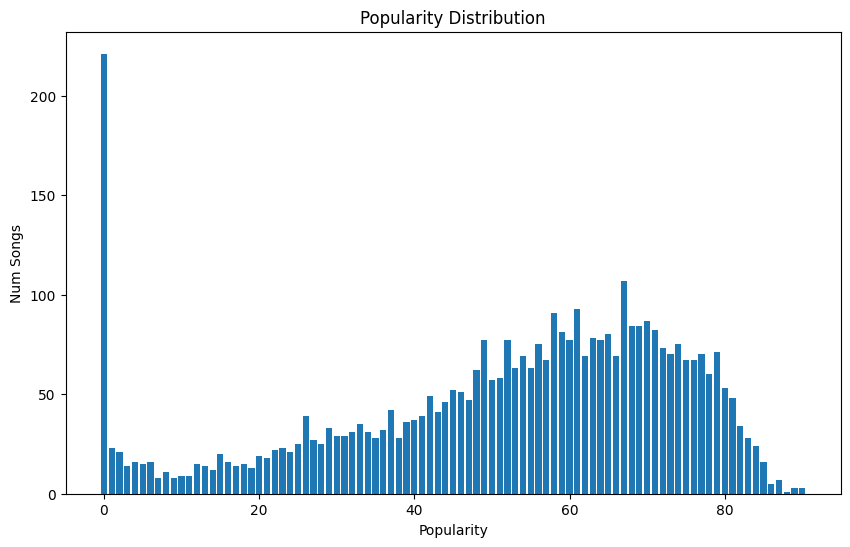

In [36]:
popularity = defaultdict(int)
for i, song in data.iterrows():
    # print(song[["Popularity"]])
    popularity[song['Popularity']] += 1

popularity = pd.DataFrame(popularity.items(), columns=["Popularity", "Num Songs"]
                             ).sort_values("Popularity")

pyplot.figure(figsize=(10, 6))
pyplot.bar(popularity["Popularity"].values, popularity["Num Songs"].values)
pyplot.xlabel(popularity.columns[0])
pyplot.ylabel(popularity.columns[1])
pyplot.title("Popularity Distribution");

print("Average song popularity: ", popularity["Popularity"].mean())
print("Median song popularity: ", popularity["Popularity"].median())
print("Max song popularity: ", popularity["Popularity"].max())

well, i'm a hipster


## Track Duration

Do I prefer long songs or short ones?


Average song lengths: 4:00.5577064812515573
Median song lengths: 3:39.27000000000001


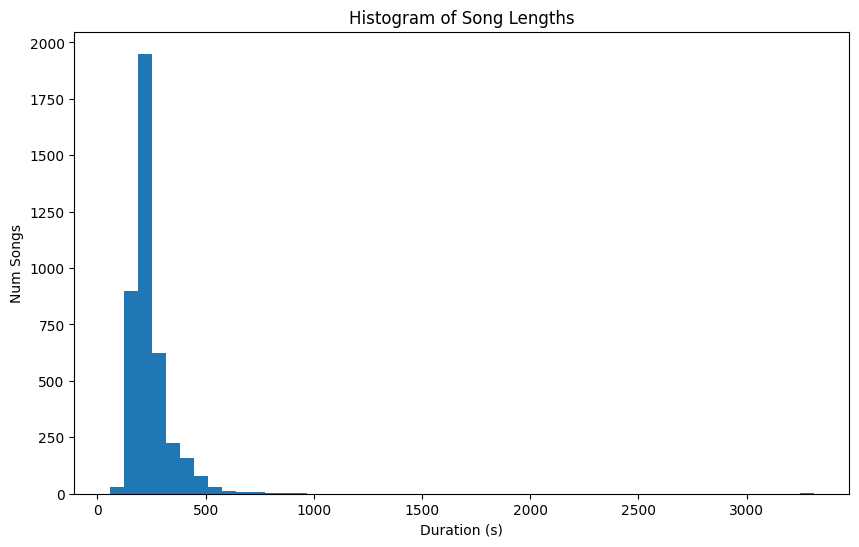

In [37]:
pyplot.figure(figsize=(10, 6))
pyplot.hist(data["Duration (ms)"]/1000, bins=50);
pyplot.xlabel("Duration (s)")
pyplot.ylabel("Num Songs")
pyplot.title("Histogram of Song Lengths")

mean = data["Duration (ms)"].mean()/1000
median = data["Duration (ms)"].median()/1000
print("Average song lengths: " + str(int(mean//60)) + (":" if mean%60 >= 10 else ":0")
      + str(mean%60))
print("Median song lengths: " + str(int(median//60)) + (":" if median%60 >= 10 else ":0")
      + str(median%60))

Median is lower than mean, so I'm right skewed. That is, I like more short songs than longer songs. What are the songs?

In [38]:
print("Longest Hall of Fame: ")
print(data[["Track Name", "Artist Name(s)", "Release Date", "Duration (ms)"]
      ].sort_values("Duration (ms)", ascending=False)[:10])

Longest Hall of Fame: 
                                   Track Name          Artist Name(s)  \
743                          Akdeb Aleik Live                   Warda   
3725                        Franco de mi amor           Madilu System   
3682                         Mario (Non stop)        Franco,TPOK Jazz   
637                                     Mario        Franco,TPOK Jazz   
3642                       Attetion Na Sida I                  Franco   
795                             Batwanes Beek                   Warda   
869                            Expensive Shit     Fela Kuti,Afrika 70   
3667  Bele:Ebale/Ya Zaïre/Faute Ya Commerçant  Simaro Massiya Lutumba   
3657                          Dede sur mesure       Zaïko Langa Langa   
2660                              Tres Impoli                  Franco   

     Release Date  Duration (ms)  
743    1990-12-31        3312720  
3725   2010-01-01         903800  
3682   1989-01-01         862040  
637    2009-01-01         815586 

Obviously Rhumba was the longest ones. I LOVE MADILU! Now on to the next one.


## Musical Features

In the interest of understanding user tastes and providing the best possible music recommendations, Spotify has done some really sophisticated analysis of actual track content. Music is a time series, but most similarity metrics (and most ML methods generally) require inputs to be vectors, that is: points in some feature-space. So they've transformed the tracks to numerical metrics like Energy and Valence (continuous) and Key (discrete).

For the continuous metrics, they provide distributions across all music. Here they are next to similar plots of my own songs.


KeyError: 'Danceability'

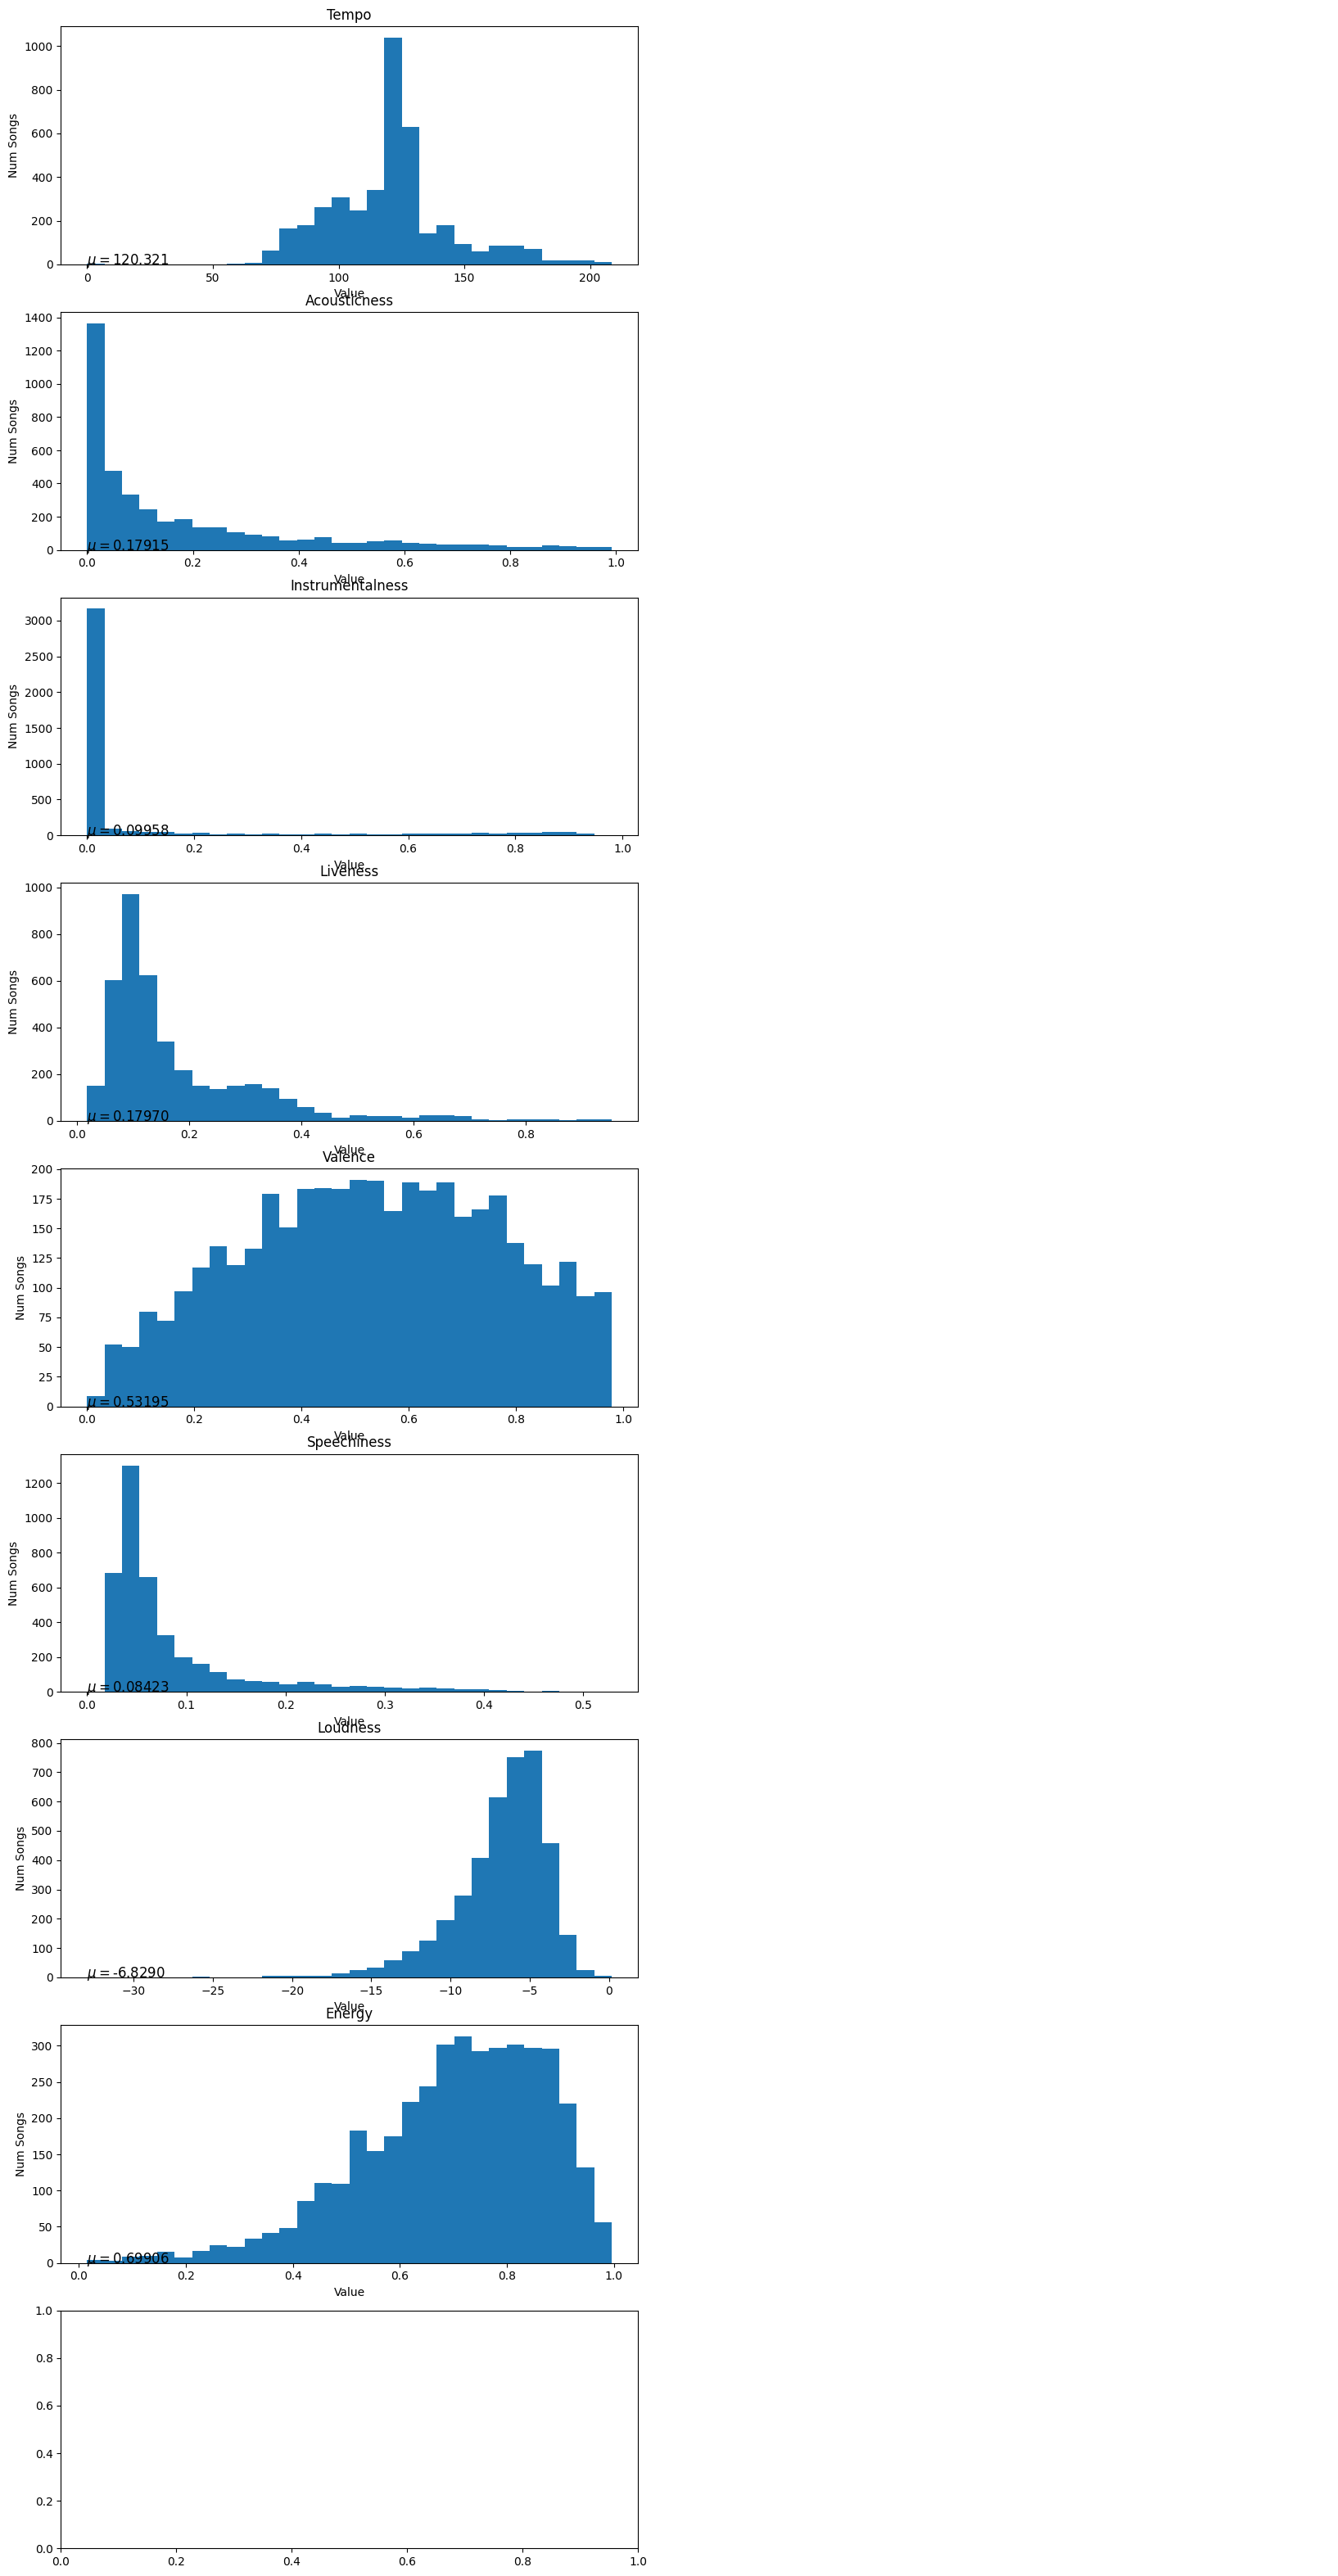

In [39]:
pyplot.figure(figsize=(20, 40))

for i, category in enumerate(["Tempo", "Acousticness", "Instrumentalness", "Liveness",
                              "Valence", "Speechiness", "Loudness", "Energy", "Danceability"]):
    pyplot.subplot(9, 2, i*2+1)
    # it will be a nice show the KDE on these plots, but there isn't a way
    # to show it on unnormalized https://github.com/mwaskom/seaborn/issues/479
    pyplot.hist(data[category], bins=30)
    pyplot.text(min(data[category]), 0, r'$\mu=$'+str(data[category].mean())[:7], fontsize=12)
    pyplot.xlabel("Value")
    pyplot.ylabel("Num Songs")
    pyplot.title(category)

    pyplot.subplot(9, 2, i*2+2)
    # pyplot.imshow(pyplot.imread("https://developer.spotify.com/assets/audio/"+category.lower()+".png"))
    pyplot.axis("off")

pyplot.tight_layout(h_pad=2)



Looks like my preferred Tempo, Energy, Danceability and Loudness are high. Energy is pretty similar, but I have perhaps slightly lower affinity for the low-energetic stuff. My Valence is somewhat positively skewed, meaning I like energetic songs than average. And my Speechiness peaks lower than average illustrating my love for beats.

Now let's look at the discrete music features.


<ipython-input-40-1590827fa6de>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=45, ha="right")
<ipython-input-40-1590827fa6de>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(["minor", "major"], rotation=45)


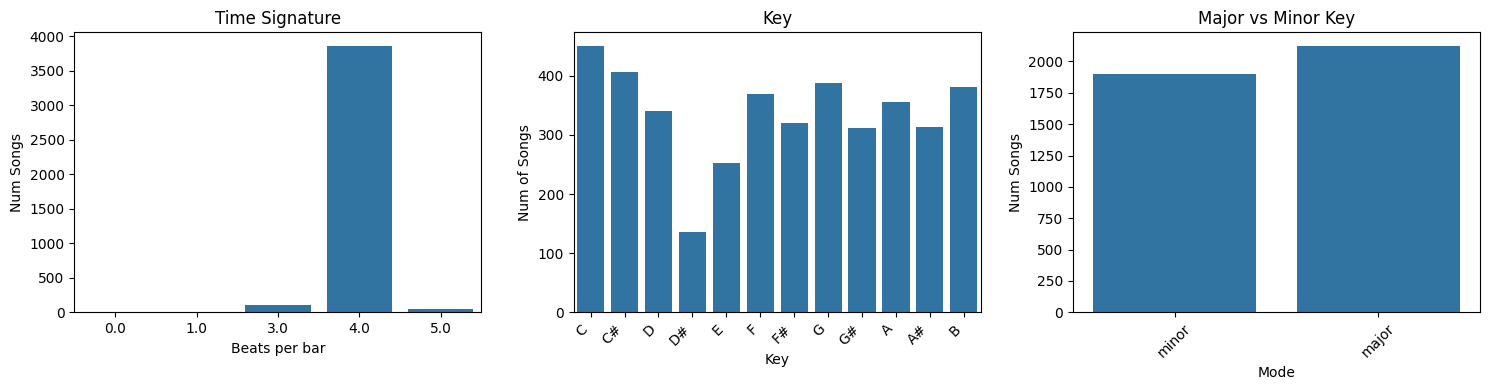

In [40]:
pyplot.figure(figsize=(15, 4))

pyplot.subplot(1, 3, 1)
seaborn.countplot(data=data, x=data["Time Signature"])
pyplot.xlabel("Beats per bar")
pyplot.ylabel("Num Songs")
pyplot.title("Time Signature")

pyplot.subplot(1, 3, 2)
axes = seaborn.countplot(data=data, x=data["Key"])
axes.set_xticklabels(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"], rotation=45, ha="right")
pyplot.ylabel("Num of Songs")
pyplot.title("Key")

pyplot.subplot(1, 3, 3)
axes = seaborn.countplot(data=data, x=data["Mode"])
axes.set_xticklabels(["minor", "major"], rotation=45)
pyplot.ylabel("Num Songs")
pyplot.title("Major vs Minor Key");

pyplot.tight_layout(w_pad=2)
pyplot.show()



Musicians seem to favour C major and C#. More than three thirds of my songs are in minor key. I don't have a baseline to compare against, but this might contribute to my high valence.

Looks like the vast majority of my music is in the 4/4 time with a few in 3/4. I wan't even aware thre were any with 5 beats. What are those?


In [41]:
print('5:\n', data.loc[data['Time Signature']==5][
    ['Track Name', 'Artist Name(s)', 'Release Date']][:20])

5:
                                Track Name                      Artist Name(s)  \
0                          Bad To Di Bone                        Brick & Lace   
87        Autumn Leaves - Remastered 1987                       Nat King Cole   
92                      You Don't Know Me                         Ray Charles   
241                    When U Feel Lonely                              Mavado   
280                 something will happen                             berlioz   
394                        All Night Long                               Marsh   
588      Come Through (feat. Chris Brown)                  H.E.R.,Chris Brown   
846                                 Oasis  Chxf Barry,mau from nowhere,Akeine   
1160                The Homeless Wanderer           Emahoy Tsege Mariam Gebru   
1181           This Is What It Feels Like     Armin van Buuren,Trevor Guthrie   
1216               Rainbow (feat. Xoli M)                  Black Motion,Xolim   
1330                    

In [42]:
print("0:\n", data.loc[data["Time Signature"]==0][
      ["Track Name", "Artist Name(s)", "Release Date"]][:10])
print("\n1:\n", data.loc[data["Time Signature"]==1][
      ["Track Name", "Artist Name(s)", "Release Date"]][:20])

0:
                          Track Name             Artist Name(s) Release Date
653                  Lovin' Feeling  French 79,Kid Francescoli   2016-10-21
1976                 You're The Top              Jeri Southern   1959-06-11
2405  Telephone (What's Your Name?)                     daste.   2020-04-15

1:
                     Track Name          Artist Name(s) Release Date
150            Now And Forever            Richard Marx   1994-01-01
710      b i g f e e l i n g s                  WILLOW   2024-05-03
867      b i g f e e l i n g s                  WILLOW   2024-04-11
1428  Still Don't Know My Name                Labrinth   2019-10-04
2398             Unendlichkeit                     CRO   2017-06-02
3028             Touch The Sky  Kanye West,Lupe Fiasco   2005-08-30



## Joint Analysis

I mostly just want to showcase what's possible. Let's plot Energy and Popularity together to see whether there is a relationship.


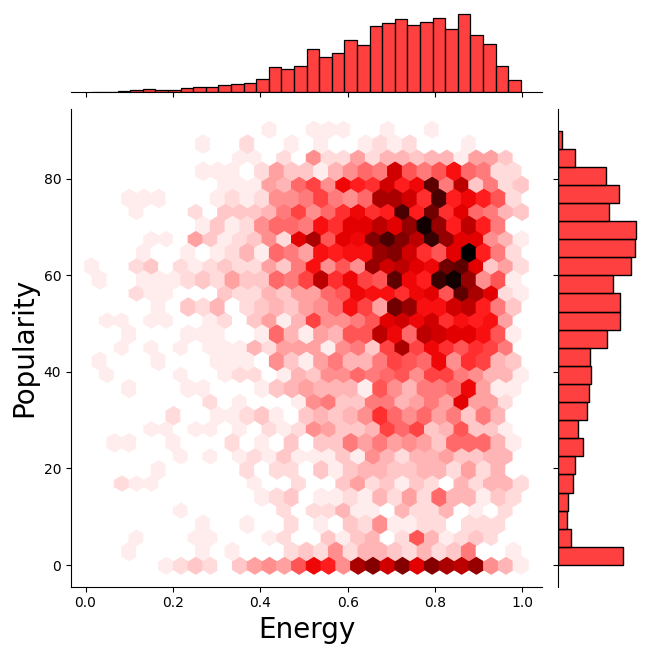

In [43]:
x = "Energy"
y = "Popularity"

axes = seaborn.jointplot(x=data[x], y=data[y], kind="hex", color='r', height=6.5)
axes.set_axis_labels(x, y, fontsize=20)
# axes.set_ylabel(y, fontsize=20)

The data is concentrated close to 80 popularity and 0.7 energy. Meaning my music choice is often characterised with high energy songs which aare also popular. But wait, there is a good chunck of songs that are lower on popularity but high in energy. Interesting, I must say.


## The Final Frontier

Finally, I'm going to follow an example from an article i read (link in README.md) and feed the dimension-reduced data to one-class SV< to get a sense of what the frontier of my normal taste looks like in that space, heat-map-of-the-universe-style.

t-SNE is a method of visualizing high-dimensional data in low-dimensio. Songs which are more alike will be nearer each other in the feature space, but we can't start with many dimensions. What we can do is reconstitute tthe points in 2D, attempting to preserve the pairwise distances, the notions of similarity, between songs.


In [44]:


show_percent =2



from sklearn.manifold import TSNE
from random import random
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.impute import SimpleImputer

# Create a dataframe of only the numerical features, all normalized so embedding
# doesn't get confused by scale differences
numerical_data = data.drop(["Spotify ID", "Artist IDs", "Track Name",
                            "Album Name", "Artist Name(s)", "Added By",
                            "Genres"], axis=1)
numerical_data["Release Date"] = pd.to_numeric(
    numerical_data["Release Date"].str.slice(0, 4))

#cont_nan = numerical_data.isnull().sum()
#print("sum of nan values:"+ str(count_nan))

numerical_data = numerical_data.dropna().reset_index(drop=True)

numerical_data = (numerical_data - numerical_data.mean()) / numerical_data.std()
print("using:", list(numerical_data.columns))

# if you like, only include a subset of there, because the results with all
# is really hard to interpret
# tsme_data = numericak_data[["Popularity", "Energy", "Acousticness",
#                               "Valence", "Loudness"]]
# print("\nConsidering similarity with respect to teh following features:")
# print(tsne_data.dtypes)

# Takes a 2D data embedding and an svm trained on it and plots the decision boundary
def plotFrontier(embedded, svm, technique_name, scale):
  # get all teh points in the space and querry the svm on them
  xx, yy = np.meshgrid(np.linspace(min(embedded[:,0])*scale,
                                   max(embedded[:,0])*scale, 500),
                       np.linspace(min(embedded[:,1])*scale,
                                   max(embedded[:,1])*scale, 500))
  Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape) # positive Z means yes, negative means outliers.

  pyplot.figure(figsize=(20, 20))
  pyplot.title("Decision Boundary of One-Class SVM in "+technique_name+" space")
  pyplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=pyplot.cm.Blues_r)
  pyplot.contour(xx, yy, Z, levels=[0], linewidths=2, colors="green") # the +/- boundary
  pyplot.contourf(xx, yy, Z, levels=[0, Z.max()], colors="lightgreen")

  pyplot.scatter(embedded[:,0], embedded[:,1], s=10, c="gray")
  for i, song in data.iterrows():
    if random() < show_percent*0.01: # randomly label % of points
    # if song["Artist Name(s)"] in ["Coldplay"]:
      x, y = embedded[i]
      pyplot.annotate(song["Track Name"], (x, y), size=10,
                      xytext=(-30, 30), textcoords="offset points",
                      ha="center", va="bottom",
                      arrowprops={"arrowstyle":"->", "color":"red"})

#cont_nan = numerical_data["Added At"].isnull().sum()
#print("sum of nan values:"+ str(count_nan))

# Removing NaN values
#data.columns

# data = data.dropna('Artist Name(s)', inplace=True)
# count the nan values
#count_nan = data['Added At'].isnull().sum()
#print("nan values: " + str(count_nan))

#data = data.dropna().reset_index(drop=True)

#count_nan = data["Added At"].isnull().sum()
#print("nan values: " + str(count_nan))
#print(numerical_data.isnull().sum())
#numerical_data.dropna(inplace=True)
#print("dropped")
#print(numerical_data.isnull().sum())

# Remomve NaN values of the data_frame
imputer = SimpleImputer(strategy="median")
numerical_data_imputed = imputer.fit_transform(numerical_data)

tsne_embedded = TSNE(n_components=2).fit_transform(numerical_data_imputed)

svm_tsne = OneClassSVM(gamma="scale")
svm_tsne.fit(tsne_embedded)

plotFrontier(tsne_embedded, svm_tsne, "t-SNE", 1.2)

KeyError: "['Spotify ID', 'Artist IDs'] not found in axis"